# Job satisfaction prediction project

Today we will try to predict job satisfaction parameter of employees using IBM dataset: https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset

We start with importing everything we need to analyze data:

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from random import randint
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')

Reading the data and looking at it's structure:

In [2]:
data = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")

In [3]:
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
Age                         1470 non-null int64
Attrition                   1470 non-null object
BusinessTravel              1470 non-null object
DailyRate                   1470 non-null int64
Department                  1470 non-null object
DistanceFromHome            1470 non-null int64
Education                   1470 non-null int64
EducationField              1470 non-null object
EmployeeCount               1470 non-null int64
EmployeeNumber              1470 non-null int64
EnvironmentSatisfaction     1470 non-null int64
Gender                      1470 non-null object
HourlyRate                  1470 non-null int64
JobInvolvement              1470 non-null int64
JobLevel                    1470 non-null int64
JobRole                     1470 non-null object
JobSatisfaction             1470 non-null int64
MaritalStatus               1470 non-null object
MonthlyIncome         

Fortunately, no values are missing. We also can notice that categorial values are described with words.

We shall split our dataset in two groups: values described with words and values described with numbers:

In [5]:
num_var = ['Age','DailyRate','DistanceFromHome','EmployeeCount','EmployeeNumber','EnvironmentSatisfaction','HourlyRate','JobInvolvement','JobLevel','MonthlyIncome','MonthlyRate','NumCompaniesWorked','PercentSalaryHike','PerformanceRating','RelationshipSatisfaction','StandardHours','StockOptionLevel','TotalWorkingYears','TrainingTimesLastYear','WorkLifeBalance','YearsAtCompany','YearsInCurrentRole','YearsSinceLastPromotion','YearsWithCurrManager', 'JobSatisfaction']
word_var = ['Attrition','BusinessTravel','Department','EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']

Let's look at our target variable:

In [6]:
values, counts = np.unique(data['JobSatisfaction'], return_counts=True)
pd.DataFrame([values, [round(i, 1) for i in counts * 100 /len(data)]],
             columns=['Low satisfaction', 'Average satisfaction', 'Hihg satisfaction', 'Very high satisfaction'],
             index=['Number', 'Distribution in %'])

,Low satisfaction,Average satisfaction,Hihg satisfaction,Very high satisfaction
Number,1.0,2.0,3.0,4.0
Distribution in %,19.7,19.0,30.1,31.2


Considering that most of the employees are satisfied with a job, we will switch from multiclass classification task to a binary classification task. It will make the task a bit easiar, but still will be very useful.

In [7]:
target_var = 'JobSatisfaction'

0 will stand for unsatisfaction and will cover Low and Average satisfaction (1 and 2), and 1 will stand for satisfaction and will cover High and Very high satisfaction (3 and 4).

In [8]:
y = np.array([0 if i <= 2 else 1 for i in data[target_var]])

Let's observe the distribution of categorial variables:

In [9]:
cat_stat = [(att, np.unique(data[att], return_counts=True)) for att in word_var]

In [10]:
for att in cat_stat:
    info = f"{att[0]} has values: "
    info_add = ""
    for i in range(len(list(att[1][0]))):
        info_add += "'" + att[1][0][i] + "': " + str(int((att[1][1][i] / sum(att[1][1])) * 100)) + "%, "
    print(info + info_add)

Attrition has values: 'No': 83%, 'Yes': 16%, 
BusinessTravel has values: 'Non-Travel': 10%, 'Travel_Frequently': 18%, 'Travel_Rarely': 70%, 
Department has values: 'Human Resources': 4%, 'Research & Development': 65%, 'Sales': 30%, 
EducationField has values: 'Human Resources': 1%, 'Life Sciences': 41%, 'Marketing': 10%, 'Medical': 31%, 'Other': 5%, 'Technical Degree': 8%, 
Gender has values: 'Female': 40%, 'Male': 60%, 
JobRole has values: 'Healthcare Representative': 8%, 'Human Resources': 3%, 'Laboratory Technician': 17%, 'Manager': 6%, 'Manufacturing Director': 9%, 'Research Director': 5%, 'Research Scientist': 19%, 'Sales Executive': 22%, 'Sales Representative': 5%, 
MaritalStatus has values: 'Divorced': 22%, 'Married': 45%, 'Single': 31%, 
Over18 has values: 'Y': 100%, 
OverTime has values: 'No': 71%, 'Yes': 28%, 


Just from the start we can say, that 'Over18' variable gives us no information and it can be thrown away. All other variables seem to be good enough. However, it is necessary to encode them properly using OneHotEncoder to continue working with them:

In [11]:
encoder = OneHotEncoder(handle_unknown='ignore')
cat_var_encoded = encoder.fit_transform(data[word_var[:-2] + [word_var[-1]]]).toarray()
cat_names = ['some_cat_' + str(i) for i in range(1, cat_var_encoded.shape[1] + 1)]

Now we will look at the distribution of numerical values:

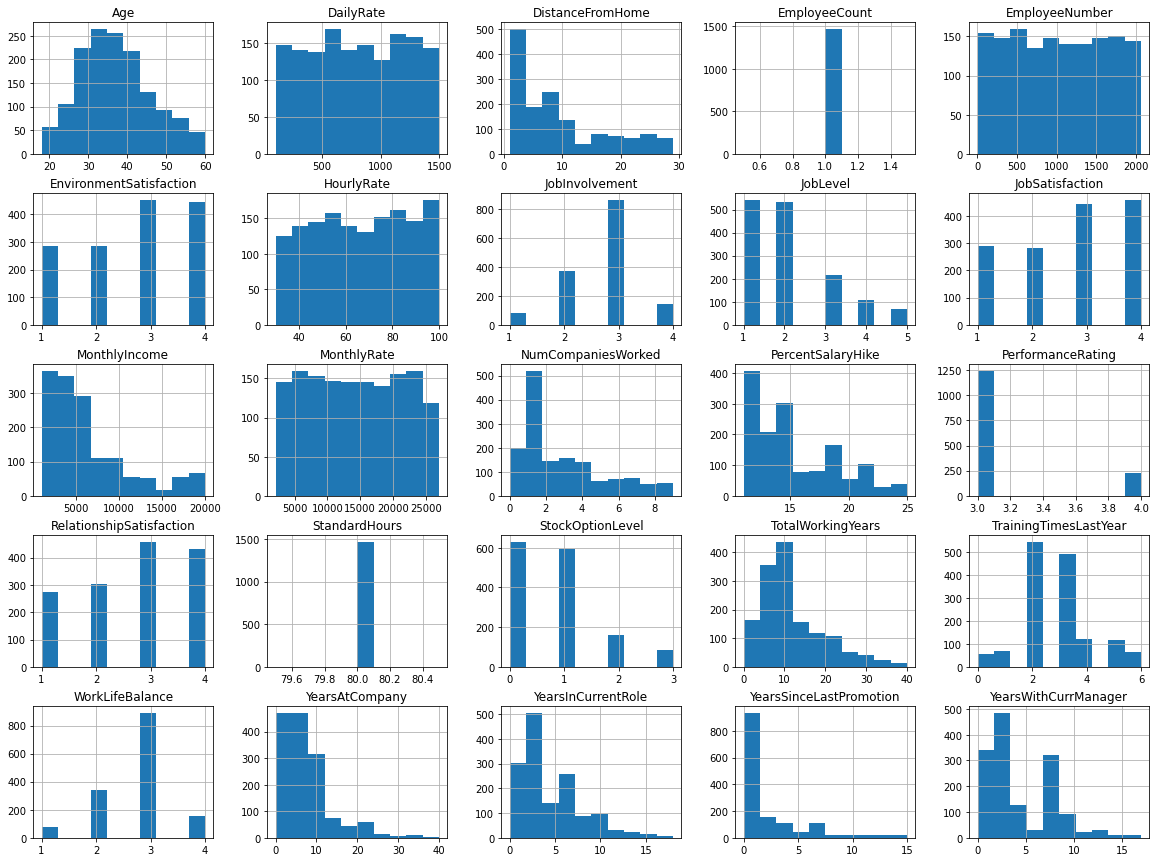

In [12]:
data[num_var].hist(figsize=(20, 15))
plt.show()

In [13]:
data[num_var].describe()

,Age,DailyRate,DistanceFromHome,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,MonthlyIncome,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobSatisfaction
count,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,6502.931293,...,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129,2.728571
std,9.135373,403.509100,8.106864,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,4707.956783,...,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136,1.102846
min,18.000000,102.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,1009.000000,...,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,30.000000,465.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,2911.000000,...,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000,2.000000
50%,36.000000,802.000000,7.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,4919.000000,...,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000,3.000000
75%,43.000000,1157.000000,14.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,8379.000000,...,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000,4.000000
max,60.000000,1499.000000,29.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,19999.000000,...,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000,4.000000


Also we will calculate mode and meadian:

In [14]:
char = ['mean', 'mode', 'median']
matrix_char = []
for var in num_var:
    var_char = [np.mean(data[var]), mode(data[var])[0][0], np.median(data[var])]
    matrix_char.append(var_char)
char_df = pd.DataFrame(matrix_char, columns=char, index=num_var)

In [15]:
char_df

,mean,mode,median
Age,36.923810,35,36.0
DailyRate,802.485714,691,802.0
DistanceFromHome,9.192517,2,7.0
EmployeeCount,1.000000,1,1.0
EmployeeNumber,1024.865306,1,1020.5
EnvironmentSatisfaction,2.721769,3,3.0
HourlyRate,65.891156,66,66.0
JobInvolvement,2.729932,3,3.0
JobLevel,2.063946,1,2.0
MonthlyIncome,6502.931293,2342,4919.0


As we can see, variables EmployeeCount and StandartHours have only one value, that is why they can be depricated. DailyRate, HourlyRate, MonthlyRate means nearly the same and are linear dependend and it is useful to leave only  MonthlyRate.

Let's depricate all mentioned variables and split variables into real and order values:

In [16]:
real_var = ['Age','DistanceFromHome','MonthlyIncome','MonthlyRate','TotalWorkingYears','YearsAtCompany', 'EmployeeNumber', 'YearsInCurrentRole','YearsSinceLastPromotion','YearsWithCurrManager']
order_var = ['EnvironmentSatisfaction','JobInvolvement','JobLevel','NumCompaniesWorked','PerformanceRating','RelationshipSatisfaction','StockOptionLevel','TrainingTimesLastYear','WorkLifeBalance']

Let's also look at pairplot of real variables in case we can spot some dependencies:

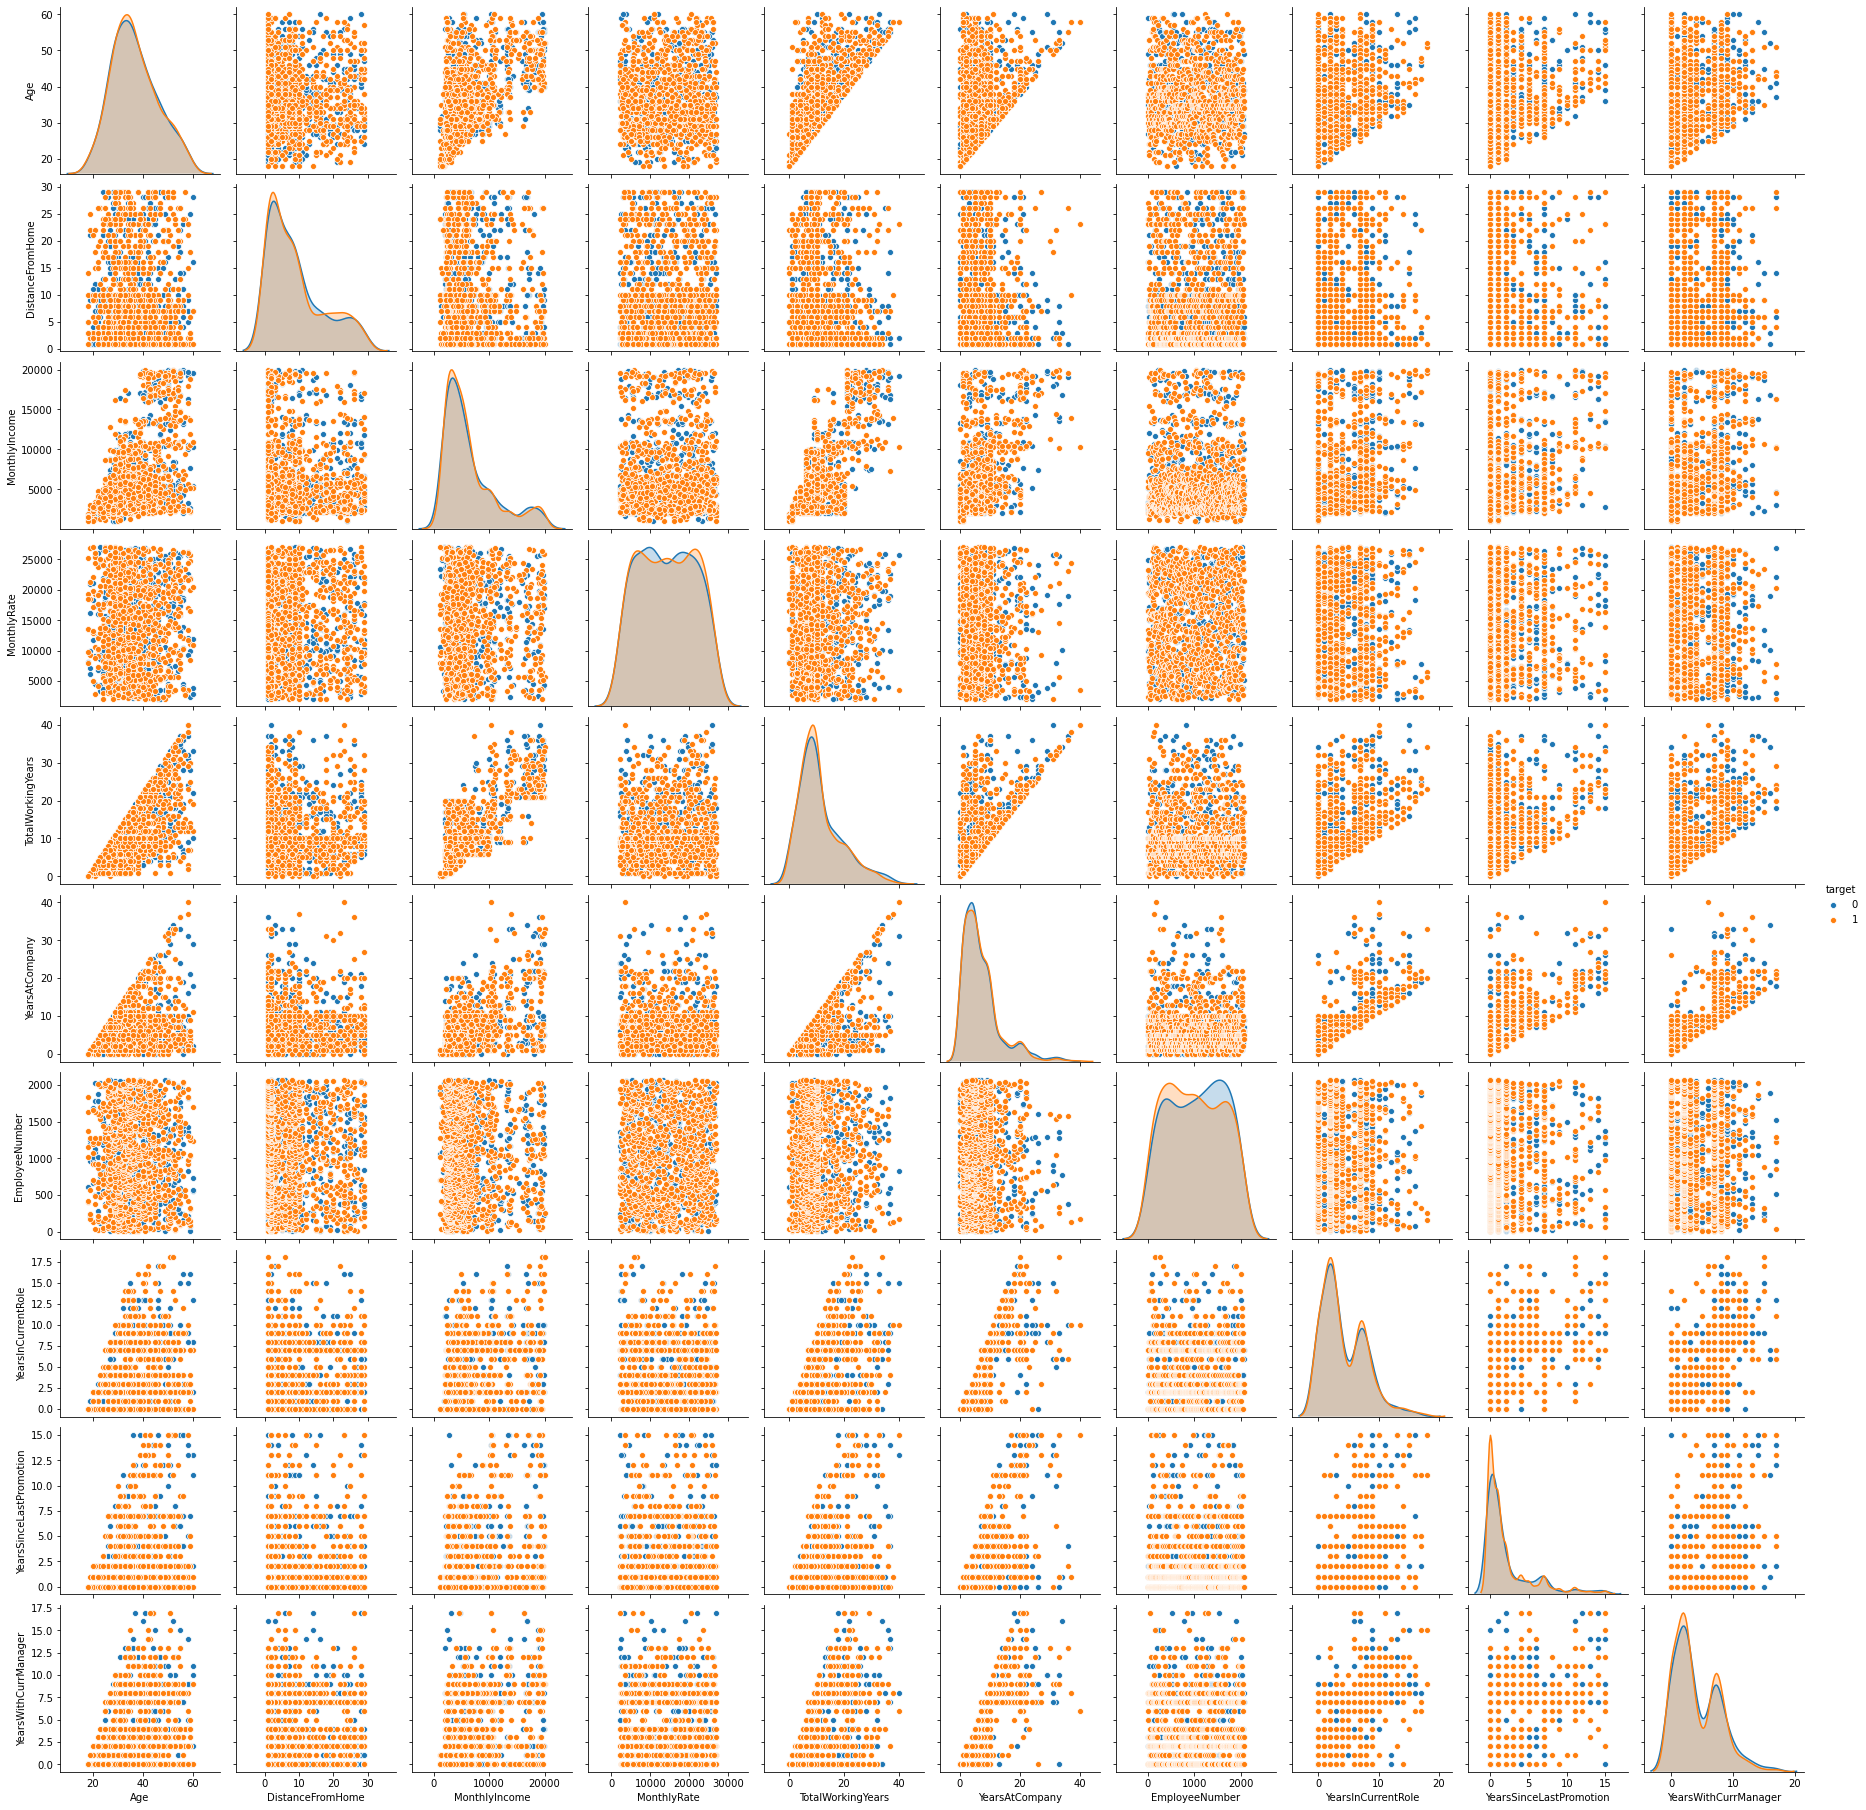

In [17]:
X_real = data[real_var]
X_real['target'] = y
sns.pairplot(X_real, hue='target')

The only major difference between classes can be seen in distribution of EmployeeNumber, but it is hard to belive that it can be a good feature, because we can enumerate employees in a different way and fully annihilate the differences.

Let's scale numerical variables to avoid divergence of some algorithms:

In [18]:
to_scale = data[real_var]
scaler = StandardScaler()
scaled_real = scaler.fit_transform(to_scale)

In [19]:
X = data[order_var]
for i in range(scaled_real.shape[1]):
    X[real_var[i]] = scaled_real[:, i]
for i in range(cat_var_encoded.shape[1]):
    X[cat_names[i]] = cat_var_encoded[:, i]

In [20]:
X.head()

,EnvironmentSatisfaction,JobInvolvement,JobLevel,NumCompaniesWorked,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,Age,...,some_cat_21,some_cat_22,some_cat_23,some_cat_24,some_cat_25,some_cat_26,some_cat_27,some_cat_28,some_cat_29,some_cat_30
0,2,3,2,8,3,1,0,0,1,0.446350,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,3,2,2,1,4,4,1,3,3,1.322365,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,4,2,1,6,3,2,0,3,3,0.008343,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,4,3,1,1,3,3,0,3,3,-0.429664,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1,3,1,9,3,4,1,3,3,-1.086676,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


Now we have variables matrix and a target variables array. We can start working with models. Our main metrics shell be ROC-AUC and accuracy.

We shall start with Decision Tree without any parametres:

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

model_tree = DecisionTreeClassifier(random_state=0)
model_tree.fit(X_train, y_train)
print(f'ROC-AUC on a train data: {round(roc_auc_score(y_train, model_tree.predict(X_train)), 3)},',
      f'ROC-AUC on a test data: {round(roc_auc_score(y_test, model_tree.predict(X_test)), 3)},',
      f'Accuracy on a test data: {round(accuracy_score(y_test, model_tree.predict(X_test)), 3)},')

ROC-AUC on a train data: 1.0, ROC-AUC on a test data: 0.52, Accuracy on a test data: 0.553,


As we can see, ROC-AUC on a train data is huge and quite low on a test data, which means our model is overfitted. Also, we can notice, that constant algorithm would have around 60% accuracy due to a class distribution. That means that our algorithm is bad and we should search for another one. We will try to find parametres using GridSearchCV:

In [22]:

params = {'criterion':['entropy', 'gini'],
          'max_depth':range(2,20),
          'min_samples_leaf':range(1, 10),
          'max_features':range(1, 20)}
search_tree = GridSearchCV(model_tree, params, n_jobs=-1, cv=5)

In [23]:
search_tree.fit(X, y)

print(f'Best score: {search_tree.best_score_}, Best parametres: {search_tree.best_params_}')

Best score: 0.619047619047619, Best parametres: {'criterion': 'gini', 'max_depth': 3, 'max_features': 16, 'min_samples_leaf': 4}


Let's also compare GridSearchCV with simple search:

In [27]:
def SimpleSearch_tree(depths, leafs, feats, X_train, X_test, y_train, y_test):
    results = []
    for depth in depths:
        for leaf in leafs:
            for feat in feats:
                model_tree = DecisionTreeClassifier(criterion='gini',
                                                max_depth=depth,
                                                min_samples_leaf=leaf,
                                                max_features=feat,
                                                random_state=0)
                model_tree.fit(X_train, y_train)
                results.append([round(roc_auc_score(y_train, model_tree.predict(X_train)), 3),
                                round(roc_auc_score(y_test, model_tree.predict(X_test)), 3),
                                round(accuracy_score(y_test, model_tree.predict(X_test)), 3),
                                (depth, leaf, feat)])
    return results

In [28]:
results = SimpleSearch_tree(range(2,20), range(1, 10), range(1, 20), X_train, X_test, y_train, y_test)

Let's look at the best estimators according to different metrics:

In [29]:
sorted(results, key=lambda x: x[1], reverse=True)[:5]

[[0.863, 0.57, 0.591, (18, 3, 10)],
 [0.863, 0.57, 0.591, (19, 3, 10)],
 [0.753, 0.563, 0.591, (10, 4, 10)],
 [0.826, 0.563, 0.574, (15, 4, 10)],
 [0.87, 0.562, 0.586, (13, 1, 4)]]

In [30]:
sorted(results, key=lambda x: x[2], reverse=True)[:5]

[[0.507, 0.51, 0.63, (4, 7, 1)],
 [0.506, 0.509, 0.628, (3, 1, 1)],
 [0.508, 0.509, 0.628, (3, 2, 1)],
 [0.508, 0.509, 0.628, (3, 3, 1)],
 [0.508, 0.509, 0.628, (3, 4, 1)]]

Very interesting results, because accuracy and ROC-AUC seems to be negatively correlated. At least our algorithm is better than a constant algorithm, which might seem like a minor achievement, however the data for both satisfied and unsatisfied employees seems to be the same and it's really hard to distinguish one from another.

We also can look on a graphical representation of the tree. Let's compare tree, which maximize ROC-AUC and tree maximizing accuracy:

In [31]:
tree_auc = DecisionTreeClassifier(criterion='gini',
                                                max_depth=18,
                                                min_samples_leaf=3,
                                                max_features=10,
                                                random_state=0)
tree_accur = DecisionTreeClassifier(criterion='gini',
                                                max_depth=4,
                                                min_samples_leaf=7,
                                                max_features=1,
                                                random_state=0)
tree_auc.fit(X_train, y_train)
tree_accur.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, max_features=1, min_samples_leaf=7,
                       random_state=0)

In [32]:
export_graphviz(tree_auc, out_file='tree_auc.dot', feature_names=X.columns)
export_graphviz(tree_accur, out_file='tree_accur.dot', feature_names=X.columns)

Tree for AUC_ROC look awfully large and most likely is overfitted. At the same time, tree for accuracy is small and most of it's leafs has the same class balance as the original train data. Also, considering that ROC_AUC metric for accuracy tree on train data is SMALLER than on test data, we can say that this tree is probably a product of pure luck. That also proves that data is very bad in terms of solving classification task and we should try to modify it in some way.

To do so, let's try using Logistic Regression and creating new features with further search for the best features.

In [33]:
model_logit_cv = LogisticRegressionCV(cv=5, penalty='l2', n_jobs=-1, random_state=0)

In [34]:
model_logit_cv.fit(X, y)

LogisticRegressionCV(cv=5, n_jobs=-1, random_state=0)

In [35]:
model_logit_cv.score(X, y)

0.6136054421768707

The overall quality is quite low again. Let's try searching for some good parametres first:

In [36]:
scorer = make_scorer(roc_auc_score)
model_logit = LogisticRegression(n_jobs=-1, random_state=0)
params = {'penalty':['elasticnet'],
          'tol':[0.01, 0.001, 0.0001, 0.00001, 0.000001],
          'C': [10 ** -3, 10 ** -2, 10 ** -1, 1, 10],
          'solver':['saga'],
          'fit_intercept':[True, False],
          'max_iter': [100, 500, 1000], 'l1_ratio': [0, 0.2, 0.5, 0.8, 1]}
search = GridSearchCV(model_logit, params, scoring=scorer, n_jobs=-1, cv=5)

In [37]:
search.fit(X, y)

GridSearchCV(cv=5, estimator=LogisticRegression(n_jobs=-1, random_state=0),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'fit_intercept': [True, False],
                         'l1_ratio': [0, 0.2, 0.5, 0.8, 1],
                         'max_iter': [100, 500, 1000],
                         'penalty': ['elasticnet'], 'solver': ['saga'],
                         'tol': [0.01, 0.001, 0.0001, 1e-05, 1e-06]},
             scoring=make_scorer(roc_auc_score))

In [38]:
print(f'Best score: {search.best_score_}, Best parametres: {search.best_params_}')

Best score: 0.5093630511602267, Best parametres: {'C': 0.1, 'fit_intercept': False, 'l1_ratio': 0, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'saga', 'tol': 0.01}


ROC-AUC score of model is low despite having optimal parametres. Maybe we can fix this with adding extra features:

In [39]:
X_pairs = X.copy()

Let's take all features except categorial features, because they are encoded with OneHotEncoder and most of them are zeros.

In [40]:
all_x = len(X.columns) - 30

We will add products and squares of real features:

In [41]:
for x in range(all_x):
    for z in range(x, all_x):
        X_pairs[f'feat_{x}_{z}'] = X_pairs[X.columns[x]] * X_pairs[X.columns[z]]

We will use RFE to find good features:

In [42]:
logit_best = LogisticRegression(penalty='elasticnet',
                                solver='saga',
                                tol=0.01,
                                C=0.1,
                                fit_intercept=False,
                                max_iter=100,
                                l1_ratio=0,
                                n_jobs=-1,
                                random_state=0)
rfe = RFE(logit_best, n_features_to_select=20)

In [43]:
rfe.fit(X_pairs, y)

RFE(estimator=LogisticRegression(C=0.1, fit_intercept=False, l1_ratio=0,
                                 n_jobs=-1, penalty='elasticnet',
                                 random_state=0, solver='saga', tol=0.01),
    n_features_to_select=20)

Let's look at 20 best features:

In [44]:
X_pairs.columns[rfe.support_]

Index(['some_cat_1', 'some_cat_2', 'some_cat_4', 'some_cat_10', 'some_cat_11',
       'some_cat_16', 'some_cat_28', 'some_cat_30', 'feat_0_12', 'feat_1_6',
       'feat_1_10', 'feat_2_12', 'feat_4_6', 'feat_8_10', 'feat_9_12',
       'feat_9_17', 'feat_10_11', 'feat_10_13', 'feat_11_18', 'feat_13_18'],
      dtype='object')

In [45]:
X_new = X_pairs[X_pairs.columns[rfe.support_]]
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y, test_size=0.33, random_state=0)

In [46]:
logit_best.fit(X_train_new, y_train_new)

LogisticRegression(C=0.1, fit_intercept=False, l1_ratio=0, n_jobs=-1,
                   penalty='elasticnet', random_state=0, solver='saga',
                   tol=0.01)

We can notice that selected features are categorial and products of real features. That happens because products of real features have more information than each real feature on it's own.

Let's also look at ROC curves for Tree and Regression:

In [47]:
y_pred_tree = tree_auc.predict_proba(X_test)
y_pred_logit = logit_best.predict_proba(X_test_new)

In [48]:
logit_x, logit_y, a = roc_curve(y_test_new, y_pred_logit[:, 1])
tree_x, tree_y, a = roc_curve(y_test, y_pred_tree[:, 1])

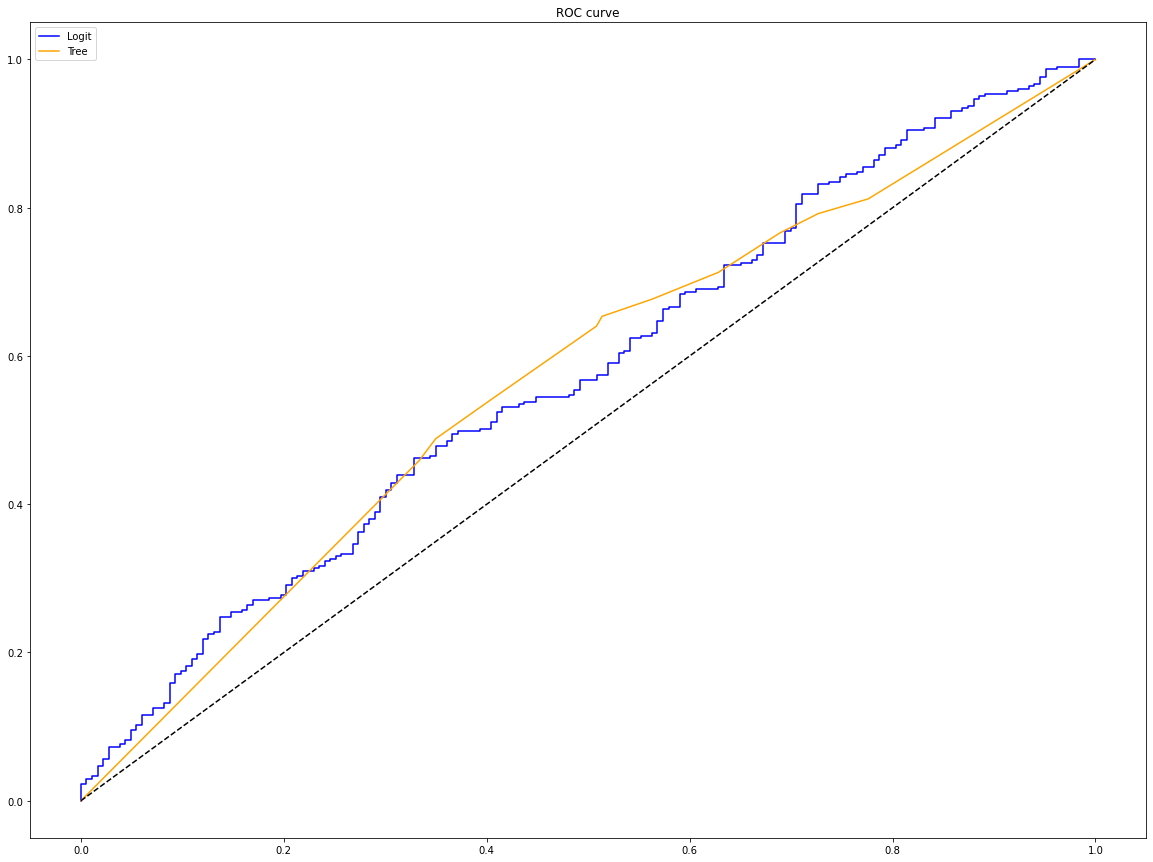

In [49]:
fig, ax = plt.subplots(figsize=(20, 15))
plt.plot(logit_x, logit_y, color='blue', label='Logit')
plt.plot(tree_x, tree_y, color='orange', label='Tree')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('ROC curve')
plt.legend()
plt.show()

In [50]:
print(f'ROC_AUC logit:{roc_auc_score(y_test_new, logit_best.predict(X_test_new))}')
print(f'Accuracy logit:{accuracy_score(y_test_new, logit_best.predict(X_test_new))}')

ROC_AUC logit:0.5395769085105232
Accuracy logit:0.6296296296296297


In [51]:
print(f'ROC_AUC tree:{roc_auc_score(y_test, tree_auc.predict(X_test))}')
print(f'Accuracy tree:{accuracy_score(y_test, tree_auc.predict(X_test))}')

ROC_AUC tree:0.5699020721744306
Accuracy tree:0.5905349794238683


The situations remains the same: we cannot reach good ROC-AUC score and accuracy score simultaneously. We can try creating more features and use different algorithm.

Let's try using random forest. At first, we will try data without pair products, then data with pair products and after that will try to search for parametres:

In [52]:
r_forest = RandomForestClassifier(random_state=0)

In [53]:
X_train_pairs, X_test_pairs, y_train_pairs, y_test_pairs = train_test_split(X_pairs, y, test_size=0.33, random_state=0)

In [54]:
r_forest.fit(X_train, y_train)
print(f'ROC_AUC random forest simple:{roc_auc_score(y_test, r_forest.predict(X_test))}')
print(f'Accuracy random forest simple:{accuracy_score(y_test, r_forest.predict(X_test))}')

ROC_AUC random forest simple:0.491830330574041
Accuracy random forest simple:0.5781893004115226


In [55]:
r_forest.fit(X_train_pairs, y_train_pairs)
print(f'ROC_AUC random forest pairs:{roc_auc_score(y_test_pairs, r_forest.predict(X_test_pairs))}')
print(f'Accuracy random forest pairs:{accuracy_score(y_test_pairs, r_forest.predict(X_test_pairs))}')

ROC_AUC random forest pairs:0.49615863225666834
Accuracy random forest pairs:0.5781893004115226


Well, the results are nearly the same. Let's try searching for parametres:

In [56]:
params = {'n_estimators':[50, 100, 200, 400],
          'max_depth':[5, 10, 15, 20],
          'min_samples_leaf':[1, 2, 3, 5, 10, 20],
          'max_features':[3, 5, 10, 20, 40]}
scorer_auc = make_scorer(roc_auc_score)
scorer_acc = make_scorer(accuracy_score)

In [57]:
i = 0
for scor in [scorer_auc, scorer_acc]:
    for train in [(X_train, y_train), (X_train_pairs, y_train_pairs)]:
        i += 1
        search = GridSearchCV(r_forest, params, scoring=scor, n_jobs=-1, cv=5)
        search.fit(train[0], train[1])
        if i == 1:
            print(f"AUC, SIMPLE. SCORE: {search.best_score_}, PARAMS: {search.best_params_}")
        elif i == 2:
            print(f"AUC, PAIRS. SCORE: {search.best_score_}, PARAMS: {search.best_params_}")
        elif i == 3:
            print(f"ACCURACY, SIMPLE. SCORE: {search.best_score_}, PARAMS: {search.best_params_}")
        elif i == 4:
            print(f"ACCURACY, PAIRS. SCORE: {search.best_score_}, PARAMS: {search.best_params_}")

AUC, SIMPLE. SCORE: 0.5220852676735029, PARAMS: {'max_depth': 20, 'max_features': 40, 'min_samples_leaf': 1, 'n_estimators': 400}
AUC, PAIRS. SCORE: 0.509807104660046, PARAMS: {'max_depth': 15, 'max_features': 40, 'min_samples_leaf': 3, 'n_estimators': 400}
ACCURACY, SIMPLE. SCORE: 0.6117839013778099, PARAMS: {'max_depth': 5, 'max_features': 10, 'min_samples_leaf': 1, 'n_estimators': 200}
ACCURACY, PAIRS. SCORE: 0.6077229876722263, PARAMS: {'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 2, 'n_estimators': 400}


Random forest don't like a lot of features and it's quality get's worse in this case. Also we can notice that algorithms maximizing AUC tend to have bigger values of max_depth and max features than algorithms maximizing accuracy.

Let's also have a glance on a confusion matrix for random forest:

In [58]:
r_f_opt = RandomForestClassifier(max_depth=20, max_features=40, min_samples_leaf=1, n_estimators=400, random_state=0)
r_f_opt.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, max_features=40, n_estimators=400,
                       random_state=0)

In [59]:
matr = confusion_matrix(y_test, r_f_opt.predict(X_test))

In [60]:
pd.DataFrame(matr, columns=[0, 1], index=[0, 1])

,0,1
0,20,163
1,43,260


In [61]:
print(f"Accuracy: {(matr[0, 0] + matr[1, 1])/(sum(matr[0]) + sum(matr[1]))}")
print(f"Precision: {(matr[1, 1]/(matr[1, 1] + matr[0, 1]))}")
print(f"Recall: {(matr[1, 1]/(matr[1, 1] + matr[1, 0]))}")

Accuracy: 0.5761316872427984
Precision: 0.6146572104018913
Recall: 0.858085808580858


As we already know, our algorithms behave like a constant-algorithms: they make a lot of False-Positive mistakes, treating almost every element as a 1-class element.

Seems that everything just doesn't work. However, we have the secret weapon and it's time to try it out. Yes, it is a Gradient Boosting.

In [62]:
gr_boost = GradientBoostingClassifier(random_state=0)

In [63]:
gr_boost.fit(X_train, y_train)
print(f'ROC_AUC Gradient Boosting:{roc_auc_score(y_test, gr_boost.predict(X_test))}')
print(f'Accuracy Gradient Boosting:{accuracy_score(y_test, gr_boost.predict(X_test))}')

ROC_AUC Gradient Boosting:0.502705188551642
Accuracy Gradient Boosting:0.5823045267489712


Traditionally, we shall find some parametres and then find some features:

In [64]:
params = {'n_estimators':[100, 300, 500],
          'max_depth':[3, 5, 12, 15],
          'min_samples_leaf':[1, 2, 3, 5, 10],
          'max_features':[5, 10, 20],
          'learning_rate':[0.001, 0.01, 0.1, 0.2, 0.5, 0.8]}
search = GridSearchCV(gr_boost, params, n_jobs=-1, cv=3)

In [65]:
search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=0),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5, 0.8],
                         'max_depth': [3, 5, 12, 15],
                         'max_features': [5, 10, 20],
                         'min_samples_leaf': [1, 2, 3, 5, 10],
                         'n_estimators': [100, 300, 500]})

In [66]:
print(f'Best score: {search.best_score_}, Best parametres: {search.best_params_}')

Best score: 0.6117886178861789, Best parametres: {'learning_rate': 0.001, 'max_depth': 15, 'max_features': 10, 'min_samples_leaf': 2, 'n_estimators': 500}


In [67]:
gr_boost_opt = GradientBoostingClassifier(random_state=0)

Now we will try searching for best variables:

In [68]:
rfe = RFE(gr_boost_opt, n_features_to_select=20)
rfe.fit(X, y)

RFE(estimator=GradientBoostingClassifier(random_state=0),
    n_features_to_select=20)

In [69]:
X.columns[rfe.support_]

Index(['EnvironmentSatisfaction', 'JobInvolvement', 'NumCompaniesWorked',
       'RelationshipSatisfaction', 'StockOptionLevel', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'Age', 'DistanceFromHome', 'MonthlyIncome',
       'MonthlyRate', 'TotalWorkingYears', 'YearsAtCompany', 'EmployeeNumber',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'some_cat_2', 'some_cat_10', 'some_cat_13'],
      dtype='object')

In [70]:
X_new = X[X.columns[rfe.support_]]
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X,
                                                                    y,
                                                                    test_size=0.33,
                                                                    random_state=0)

In [71]:
search.fit(X_train_new, y_train_new)
print(f'Best score: {search.best_score_}, Best parametres: {search.best_params_}')

Best score: 0.6117886178861789, Best parametres: {'learning_rate': 0.001, 'max_depth': 15, 'max_features': 10, 'min_samples_leaf': 2, 'n_estimators': 500}


To conclude, even gradient boosting cannot handle this classification task. That means that data for both classes is nearly the same and models can't find any variables that significantly differ from class to class. We should consider that data is artificially created by IBM specialists and may not reflect the situation in this kind of tasks. Nevertheless, we can say that job satisfaction of employees does not primarily depend on presented features. Maybe their job satisfaction depend on their mood today or some other random factors.